# Running quantum circuits on QPU devices

In this tutorial, we demonstrate how to run circuits on QPU devices. Whether you want to run your circuit on a specific backend or want to switch between backends, qBraid Lab offers the flexibility to seamlessly swap between different devices without any modifications to the circuit definition. We further demonstrate how to recover results using the unique ARN associated with every task. This tool is useful in order to deal with potential delays if your quantum task sits in the queue for some time waiting for execution. 

<h1 style="color:#D30982;">qBraid instructions</h1> 

If you are not planning to submit jobs to quantum computers, this notebook should work well with the `Python [Default]` kernel. If you want to submit jobs to quantum computers, make sure that you have installed the amazon braket environment on qBraid ([installation instructions](https://qbraid-qbraid.readthedocs-hosted.com/en/latest/lab/environments.html#install-environment)) and have selected the `Python [Braket]` kernel. (You can switch kernels by going to the Menu Bar → Kernel → Change Kernel).

If you do not have AWS credentials for submitting your quantum jobs, you will need qBraid Credits. If you have qBraid Credits, you can run the following line of code to submit quantum jobs through qBraid:

In [ ]:
#!qbraid jobs enable amazon_braket #You only need to run this line once after you install the environment

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Instruction, circuit, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask
s3_folder = ("dummy_variable", "dummy_variable")

### Supported gate sets by different devices

First, let us check out the gate set currently supported by our SDK. Note that the QPU devices only support a subset of these gates.

In [3]:
# Print all the available gates currently available within SDK

gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print("Gate set supported by SDK:\n", gate_set)
print("\n")

# The IQM Garnet device
device = AwsDevice("arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet")
supported_gates = device.properties.action[
    "braket.ir.openqasm.program"
].supportedOperations
# print the supported gate set
print("Gate set supported by the IQM device:\n", supported_gates)

Gate set supported by SDK:
 ['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CV', 'CY', 'CZ', 'ECR', 'GPhase', 'GPi', 'GPi2', 'H', 'I', 'ISwap', 'MS', 'PRx', 'PSwap', 'PhaseShift', 'PulseGate', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'U', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']




ClientError: An error occurred (UnrecognizedClientException) when calling the GetDevice operation: The security token included in the request is invalid.

### Sample Problem: Prepare Bell State

Goal: Prepare the maximally entangled Bell state: 
$$\left|0,0\right> \rightarrow \left|\mathrm{Bell}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0\right> + \left|1,1\right>\right).$$

To achieve this, we build and run the following circuit using a single-qubit Hadamard gate (denoted as ```H```) acting on the first qubit followed by a two-qubit ```CNOT``` gate.

### Setup Circuit

In [6]:
# define circuit
bell = Circuit().h(0).cnot(0, 1)

In [7]:
# print circuit
print(bell)

T  : │  0  │  1  │
      ┌───┐       
q0 : ─┤ H ├───●───
      └───┘   │   
            ┌─┴─┐ 
q1 : ───────┤ X ├─
            └───┘ 
T  : │  0  │  1  │


### Local Simulator

First we run our circuit locally, using an exact state-vector simulator. This local simulator is the preferred choice for fast experiments with low to intermediate qubit numbers ($N<20-25$) and essentially unlimited circuit depth. 

In [8]:
# set up device: Local Simulator
device = LocalSimulator()

In [9]:
# run circuit (execute single TASK)
result = device.run(bell, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'11': 509, '00': 491})


Text(0, 0.5, 'counts')

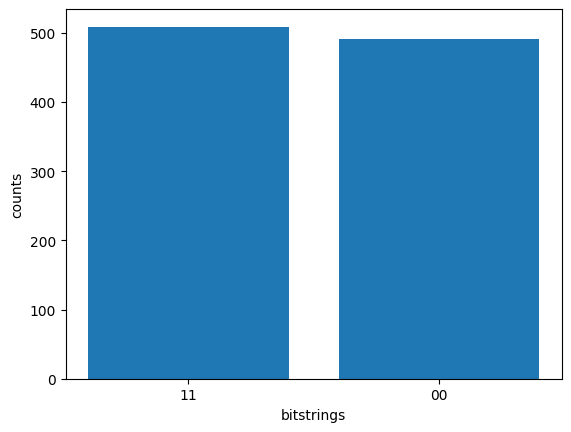

In [10]:
# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')

### Quantum Hardware: IQM Garnet

Next we submit our circuit to the superconducting hardware provided by IQM Garnet. Depending on our position in the queue, we may have to wait for some time till our circuit is actually run. However, thanks to asynchronous execution, we can always come back and recover the results by providing the unique ID associated with every task. 

In [11]:
# set up device
iqm = AwsDevice("arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet")

# create a clean circuit with no result type attached.(This is because some result types are only supported when shots=0)
bell = Circuit().h(0).cnot(0, 1)

# add the Z \otimes Z expectation value
bell.expectation(Observable.Z() @ Observable.Z(), target=[0, 1])

# run circuit
iqm_task = iqm.run(bell, shots=10)

# get id and status of submitted task
iqm_task_id = iqm_task.id
iqm_status = iqm_task.state()
# print('ID of task:', iqm_task_id)
print("Status of task:", iqm_status)

Status of task: QUEUED


The task is submitted and we can regularly (or irregularly) check the status of this task by executing the following cell. You may easily build logic around this query to wait for this task to complete before your code proceeds. 

In [12]:
# print status
status = iqm_task.state()
print('Status of (reconstructed) task:', status)

Status of (reconstructed) task: QUEUED


Note that in order to submit our job to the new device, we simply had to set the device variable as `AwsDevice("arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet")`. The rest of the code stayed the same! Additionally, this task may not readily be executed, but enter a queue for this specific machine. While we can interrupt our kernel (and work on something else), we can always recover our results using the unique ID of this task.

### Task Recovery

By simply grabbing the unique task ID associated with the quantum tasks we have submitted above, we can recover this task at any point in time and (once the status is completed) visualize and analyze the corresponding results. Note that apart from other metadata, you can retrieve the compiled circuit that was actually run on the IQM Garnet device.

In [13]:
# recover task
task_load = AwsQuantumTask(arn=iqm_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)
print('\n')
# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    iqm_results = task_load.result()
    # print(iqm_results)
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.\n".format(shots, machine))
    
    # get the compiled circuit
    print("The compiled circuit is:\n", iqm_results.additionalMetadata.iqmMetadata.compiledProgram)
    
    # get measurement counts
    iqm_counts = iqm_results.measurement_counts
    print('Measurement counts:', iqm_counts)

    # plot results: see effects of noise
    plt.bar(iqm_counts.keys(), iqm_counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig('iqm.png', dpi=700)
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

Status of (reconstructed) task: QUEUED


Sorry, your task is still being processed and has not been finalized yet.


In [16]:
# recover task
task_load = AwsQuantumTask(arn=iqm_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task_load.result()
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.".format(shots, machine))
    
    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig('bell_ionq.png', dpi=700)
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

Status of (reconstructed) task: QUEUED
Sorry, your task is still being processed and has not been finalized yet.


We have successfully recovered the results associated with the tasks that were queued up for the quantum hardware providers. Because of noise (decoherence) and other imperfections, we may not be able to fully recover the exact results we have seen when using the classical simulator. In the future, better error correction techniques will ensure that the accuracy of the calculations matches the simulation on a much wider scale. Until fault-tolerant quantum computing is a reality, it is important to benchmark our quantum results using classical simulators, whenever possible. 

---
# APPENDIX

In [ ]:
# set up device
iqm = AwsDevice("arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet")

# run circuit
task = iqm.run(bell, s3_folder ,shots=10)
print('Information on task:\n', task)
print('==================================' * 2)

# get status of submitted task
status = task.state()

# wait for job to complete
terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
while status not in terminal_states:
    status = task.state()
    print('Status:', status)
    # time.sleep(60)

print('Status:', status)

# get results
iqm_results = task.result()
print(iqm_results)

# get measurement counts
iqm_counts = iqm_results.measurement_counts
print(iqm_counts)

# plot results: see effects of noise
plt.bar(iqm_counts.keys(), iqm_counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.tight_layout()
plt.savefig('iqm2.png', dpi=700)